In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import mne
from scipy.signal import coherence
from networkx.algorithms import community
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

# Configuración global
SFREQ = 160.0
FMIN = 8
FMAX = 30

def limpiar_nombres_canales(df):
    if df.empty: return []
    # Intentamos obtener nombres de columnas o índice
    nombres = df.columns.astype(str).str.strip().str.replace('.', '', regex=False).tolist()
    return nombres

def procesar_sujeto(df_sujeto):
    # 1. Limpieza básica de columnas de tiempo si existen
    cols_drop = [c for c in df_sujeto.columns if 'time' in str(c).lower() or 'Unnamed' in str(c)]
    if cols_drop:
        df_sujeto = df_sujeto.drop(columns=cols_drop)

    ####tengo que detectar si es una matriz
    filas, cols = df_sujeto.shape
    
    
    if abs(filas - cols) < 5: 
        df_final = df_sujeto.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        ####limpiar nombres de índice y columnas para que coincidan con coordenadas
        clean_cols = [str(c).strip().replace('.', '') for c in df_final.columns]
        df_final.columns = clean_cols
        df_final.index = clean_cols # Asumimos simetría
        
        ###validación de seguridad: Valores entre 0 y 1
        if df_final.values.max() > 1.5: # Un margen por si acaso
            print("   (Advertencia: Valores mayores a 1 detectados en matriz pre-calculada)")
            
        return df_final

    if filas > cols:
        data = df_sujeto.values.T
        ch_names = limpiar_nombres_canales(df_sujeto)
    else:
        data = df_sujeto.values
        ch_names = df_sujeto.index.astype(str).str.strip().str.replace('.', '', regex=False).tolist()

    ###validación longitud señal cruda
    if data.shape[1] < 100:
        # Aquí caía tu error antes, pero ahora solo llegamos aquí si NO era cuadrada
        raise ValueError(f"Señal cruda demasiado corta ({data.shape[1]} muestras).")

    # MNE y Coherencia
    info = mne.create_info(ch_names=ch_names, sfreq=SFREQ, ch_types='eeg')
    raw = mne.io.RawArray(data, info, verbose=False)
    raw.filter(FMIN, FMAX, fir_design='firwin', verbose=False)
    data_filt = raw.get_data()
    
    n = len(ch_names)
    matriz = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            f, Cxy = coherence(data_filt[i], data_filt[j], fs=SFREQ, nperseg=int(SFREQ/2))
            mask = (f >= FMIN) & (f <= FMAX)
            val = np.mean(Cxy[mask]) if np.any(mask) else 0
            matriz[i, j] = val
            matriz[j, i] = val
            
    return pd.DataFrame(matriz, index=ch_names, columns=ch_names)

def lista_dfs(dict_sheets):
    lista_resultados = []
    print(f"Procesando {len(dict_sheets)} sujetos...")
    
    errores = 0
    for nombre, df in dict_sheets.items():
        try:
            # Procesamos cada hoja
            matriz = procesar_sujeto(df)
            
            # Verificación: que no esté vacía o sea ceros
            if matriz.empty or matriz.values.sum() == 0:
                # print(f"Advertencia: Sujeto {nombre} vacío o ceros.") 
                pass
            else:
                lista_resultados.append(matriz)
        except Exception as e:
            errores += 1
            if errores <= 3: 
                print(f"Error en '{nombre}': {e}")
            continue
            
    print(f"Finalizado. Exitosos: {len(lista_resultados)}. Fallidos: {errores}")
    return lista_resultados

def capsula(lista_dfs, umbral_coherencia, umbral_poblacion):
    if not lista_dfs: return pd.DataFrame()
    
    # Buscar intersección de canales (asegurar que todos tengan las mismas dimensiones)
    common = lista_dfs[0].index
    for df in lista_dfs[1:]:
        common = common.intersection(df.index)
    common = sorted(list(common))
    
    if not common: return pd.DataFrame()
    
    # Filtrar solo canales comunes
    stack = np.array([(df.loc[common, common].values > umbral_coherencia).astype(int) for df in lista_dfs])
    
    probabilidad = np.mean(stack, axis=0)
    final = (probabilidad > umbral_poblacion).astype(float)
    np.fill_diagonal(final, 0)
    
    return pd.DataFrame(final, index=common, columns=common)

def metricas_grafo(G):
    if len(G.nodes) == 0: return (0,0,0,[],0,{},0,0,{})
    try:
        comunidades = list(community.greedy_modularity_communities(G))
        modularity = community.modularity(G, comunidades)
    except:
        comunidades = list(nx.connected_components(G))
        modularity = 0
    clust_coeff = nx.average_clustering(G)
    try:
        path_length = nx.average_shortest_path_length(G)
        sigma = nx.sigma(G, niter=5, nrand=5)
    except:
        path_length = 0; sigma = 0
    betwenness = nx.betweenness_centrality(G)
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)
    degree_dict = dict(G.degree())
    return (clust_coeff, path_length, sigma, comunidades, modularity, betwenness, global_eff, local_eff, degree_dict)

def grafo2D(df, ax):
    if df.empty: return
    G = nx.from_pandas_adjacency(df)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, node_size=50, with_labels=True, font_size=8)
    ax.set_title("Grafo 2D")

def grafo3D(coords, hub_info, ax):
    if coords.empty: return
    # Filtrar solo los que existen en coords
    ax.scatter(coords['x'], coords['y'], coords['z'], c='blue', alpha=0.2)
    hub_name = hub_info[0] if isinstance(hub_info, tuple) else hub_info
    if hub_name in coords.index:
        hx, hy, hz = coords.loc[hub_name, ['x','y','z']]
        ax.scatter([hx], [hy], [hz], c='red', s=100)
        ax.text(hx, hy, hz, str(hub_name))

def grafo_comunidades(comunidades, hub_info, coords, ax):
    if coords.empty or not comunidades: return
    colores = plt.cm.jet(np.linspace(0, 1, len(comunidades)))
    for i, com in enumerate(comunidades):
        nodos = [n for n in com if n in coords.index]
        if nodos:
            ax.scatter(coords.loc[nodos,'x'], coords.loc[nodos,'y'], coords.loc[nodos,'z'], color=colores[i], s=40)

In [11]:
ensayo3_excel = r"C:\Users\HP\Documents\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_03.xlsx"
ensayo4_excel = r"C:\Users\HP\Documents\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_04.xlsx"
coordenadas_csv = r"C:\Users\HP\Documents\GitHub\Neurociencias-2026-1\S03_datasets\MI_coordinates.csv"

# Cargar Diccionarios
ensayo3_dict = pd.read_excel(ensayo3_excel, sheet_name=None, index_col=None)
ensayo4_dict = pd.read_excel(ensayo4_excel, sheet_name=None, index_col=None)

# Procesar (Esto imprimirá errores si falla)
ensayos3_dfs = lista_dfs(ensayo3_dict)
ensayos4_dfs = lista_dfs(ensayo4_dict)

# Cargar Coordenadas
try:
    eeg_coords = pd.read_csv(coordenadas_csv)
    if 'label' in eeg_coords.columns: eeg_coords.rename(columns={'label':'canal'}, inplace=True)
    eeg_coords['canal'] = eeg_coords['canal'].astype(str).str.strip().str.replace('.', '', regex=False)
    eeg_coords.set_index("canal", inplace=True)
except Exception as e:
    print("Error cargando coordenadas:", e)
    eeg_coords = pd.DataFrame()

Procesando 109 sujetos...
Finalizado. Exitosos: 109. Fallidos: 0
Procesando 109 sujetos...
Finalizado. Exitosos: 109. Fallidos: 0


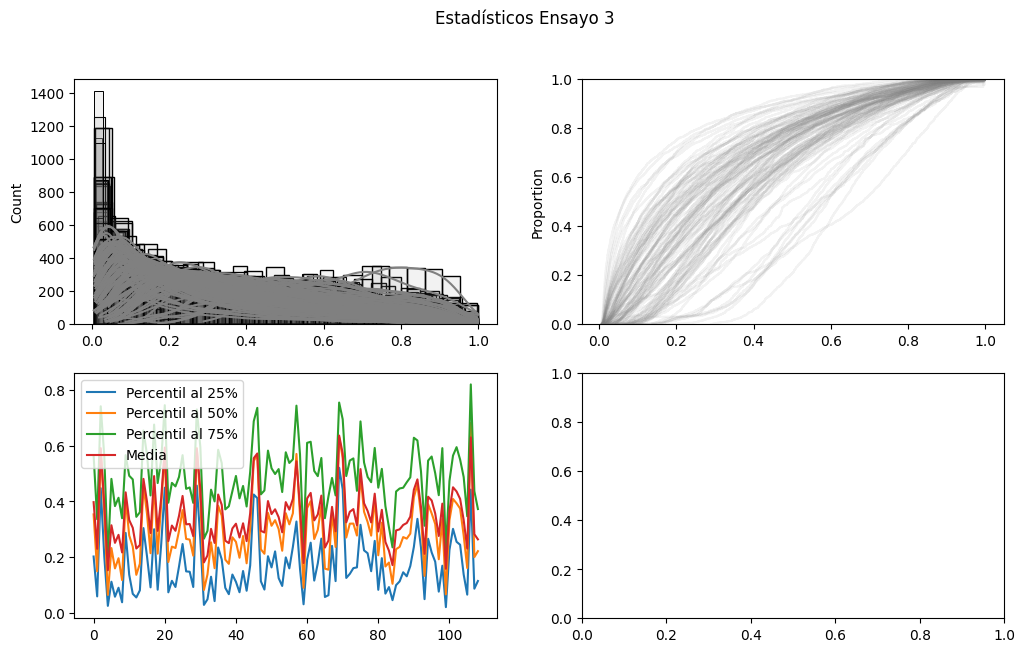

,th25,th50,promedio
min,0.019688,0.063866,0.152199
max,0.520979,0.682192,0.636798
mediana,0.148939,0.277594,0.332901
mad,0.068771,0.080368,0.064502


In [12]:
# Análisis para ensayo3
ensayos_dfs = ensayos3_dfs

th25, th50, th75, promedio, varianza = [], [], [], [], []
mu_sigma = []

if not ensayos_dfs:
    print("!!! ERROR CRÍTICO: La lista 'ensayos_dfs' está vacía.")
    print("Revisa la Celda 2: ¿La ruta del Excel es correcta? ¿El Excel tiene datos?")
else:
    fig, axes = plt.subplots(2,2, figsize=(12,7))

    for sujeto in ensayos_dfs:
        data = sujeto.values.flatten()
        data = data[data > 0]
        
        if len(data) == 0: continue
            
        th25.append(np.percentile(data, 25))
        th50.append(np.percentile(data, 50))
        th75.append(np.percentile(data, 75))
        promedio.append(np.mean(data))
        varianza.append(np.var(data))
        
        sns.histplot(data, ax=axes[0][0], kde=True, alpha=0.1, color='gray') 
        sns.ecdfplot(data, ax=axes[0][1], alpha=0.1, color='gray')

    # VERIFICACIÓN ANTES DE CALCULAR MIN/MAX
    if not th25:
        print("!!! ADVERTENCIA: Se procesaron los sujetos, pero las matrices de coherencia resultaron vacías o de ceros.")
        print("Intenta ajustar FMIN, FMAX o revisa si los datos del Excel son válidos.")
    else:
        # Solo ejecutamos esto si las listas tienen datos
        axes[1][0].plot(th25, label="Percentil al 25%")
        axes[1][0].plot(th50, label="Percentil al 50%")
        axes[1][0].plot(th75, label="Percentil al 75%")
        axes[1][0].plot(promedio, label="Media")
        axes[1][0].legend()
        plt.suptitle("Estadísticos Ensayo 3")
        plt.show()

        # DataFrame resumen estadístico
        estadisticos_df = pd.DataFrame({
            'th25': [np.min(th25), np.max(th25), np.median(th25), stats.median_abs_deviation(th25)],
            'th50': [np.min(th50), np.max(th50), np.median(th50), stats.median_abs_deviation(th50)],
            'promedio': [np.min(promedio), np.max(promedio), np.median(promedio), stats.median_abs_deviation(promedio)]
        }, index=['min', 'max', 'mediana', 'mad'])

        display(estadisticos_df)

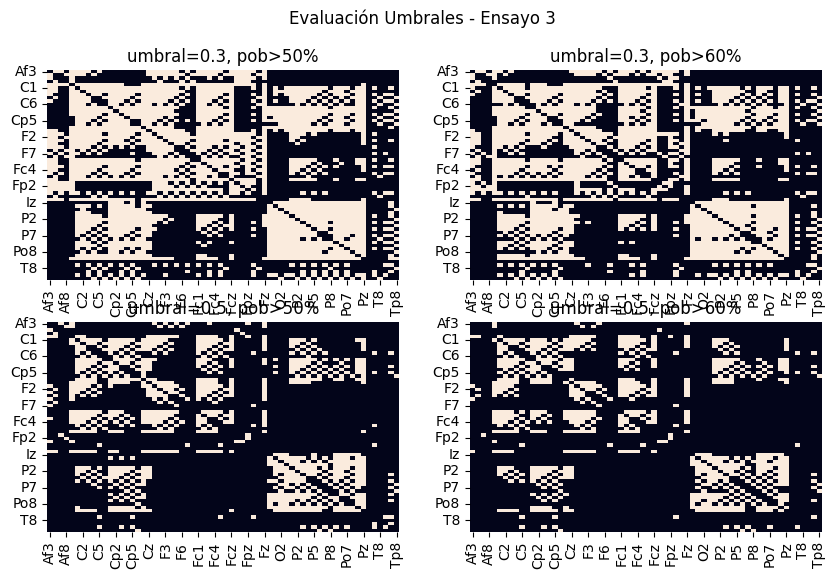

In [13]:
# comparativas entre valores de threshold --> evaluar cuál es el mejor umbral
# Ajusta los valores (0.3, 0.5, etc) según lo que viste en la celda anterior

resultado3_df1 = capsula(ensayos3_dfs, 0.3, 0.5)
resultado3_df2 = capsula(ensayos3_dfs, 0.3, 0.6)
resultado3_df3 = capsula(ensayos3_dfs, 0.5, 0.5)
resultado3_df4 = capsula(ensayos3_dfs, 0.5, 0.6)

fig, axes = plt.subplots(2,2, figsize = (10, 6))

sns.heatmap(resultado3_df1, ax=axes[0, 0], cbar=False)
sns.heatmap(resultado3_df2, ax=axes[0, 1], cbar=False)
sns.heatmap(resultado3_df3, ax=axes[1, 0], cbar=False)
sns.heatmap(resultado3_df4, ax=axes[1, 1], cbar=False)

axes[0,0].set_title("umbral=0.3, pob>50%")
axes[0,1].set_title("umbral=0.3, pob>60%")
axes[1,0].set_title("umbral=0.5, pob>50%")
axes[1,1].set_title("umbral=0.5, pob>60%")

fig.suptitle('Evaluación Umbrales - Ensayo 3')
plt.show()

# Elegimos matrices definitivas (Ejemplo)
resultado3_final = resultado3_df2
resultado4_final = capsula(ensayos4_dfs, 0.3, 0.6) # Usamos mismos parametros para el 4

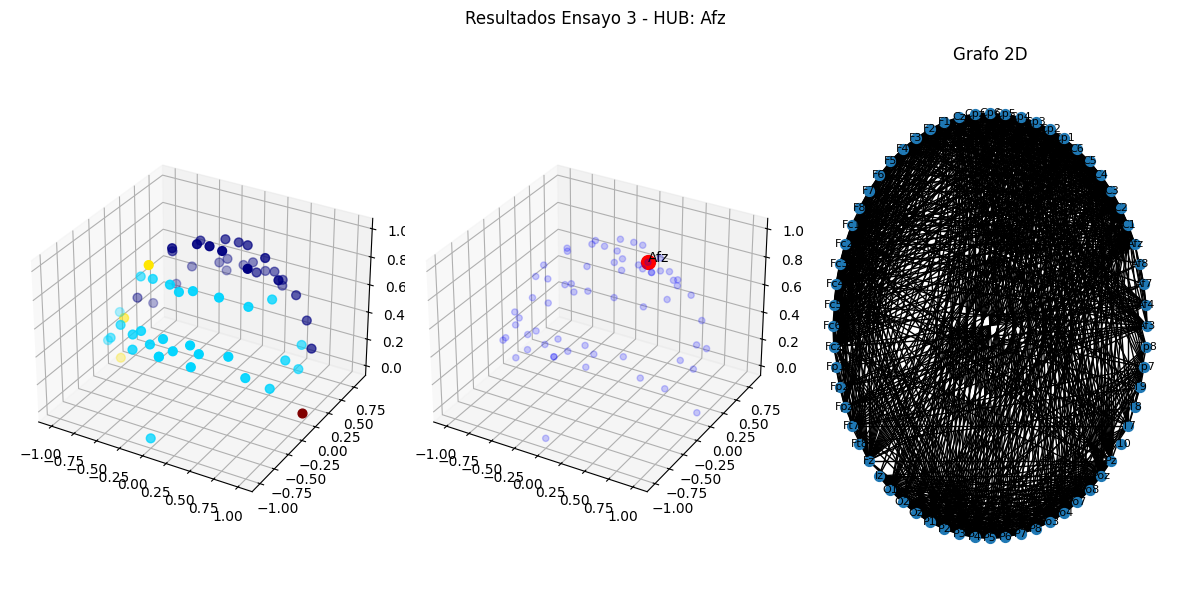

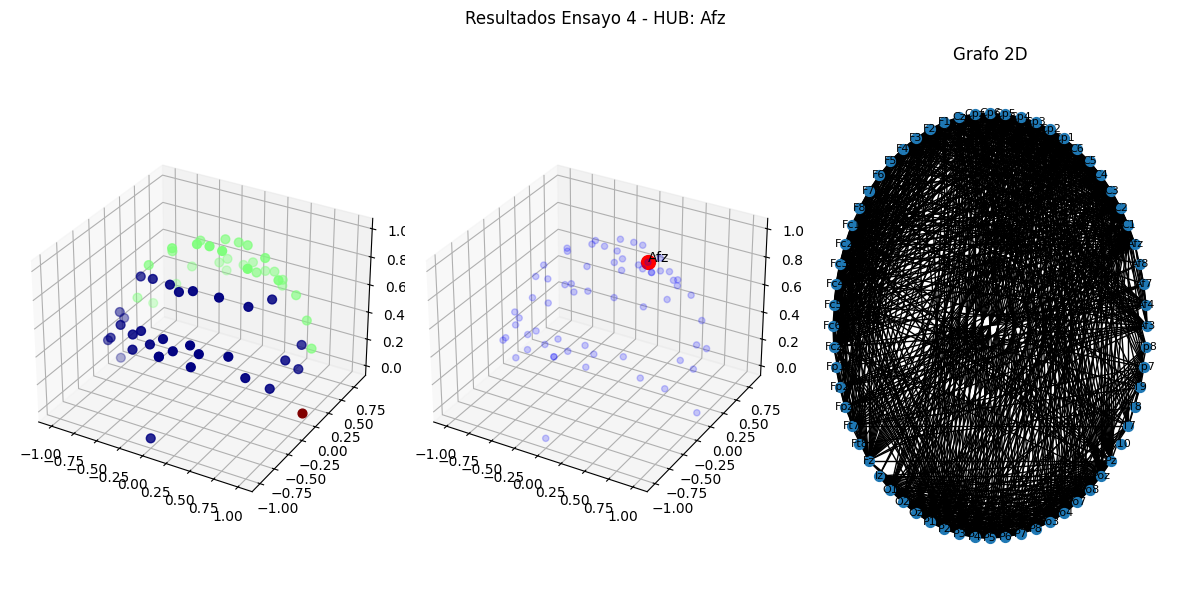

In [14]:
# Convertir de dataframe a grafo
ensayo3_grafo_ = nx.from_pandas_adjacency(resultado3_final)
ensayo4_grafo_ = nx.from_pandas_adjacency(resultado4_final)

# Cálculo de métricas por ensayo
(clust_3, path_3, sigma_3, comms_3, mod_3, bet_3, glob_3, loc_3, deg_3) = metricas_grafo(ensayo3_grafo_)
(clust_4, path_4, sigma_4, comms_4, mod_4, bet_4, glob_4, loc_4, deg_4) = metricas_grafo(ensayo4_grafo_)

# --- PLOT 3D ENSAYO 3 ---
hub3 = sorted(bet_3.items(), key=lambda x: x[1], reverse=True)[0] if bet_3 else ("Nan",0)

fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(1, 3, 1, projection='3d'), 
        fig.add_subplot(1, 3, 2, projection='3d'), 
        fig.add_subplot(1, 3, 3)]

grafo_comunidades(comms_3, hub3, eeg_coords, axes[0])
grafo3D(eeg_coords, hub3, axes[1])
grafo2D(resultado3_final, axes[2])
plt.suptitle(f"Resultados Ensayo 3 - HUB: {hub3[0]}")
plt.tight_layout()
plt.show()

# --- PLOT 3D ENSAYO 4 ---
hub4 = sorted(bet_4.items(), key=lambda x: x[1], reverse=True)[0] if bet_4 else ("Nan",0)

fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(1, 3, 1, projection='3d'), 
        fig.add_subplot(1, 3, 2, projection='3d'), 
        fig.add_subplot(1, 3, 3)]

grafo_comunidades(comms_4, hub4, eeg_coords, axes[0])
grafo3D(eeg_coords, hub4, axes[1])
grafo2D(resultado4_final, axes[2])
plt.suptitle(f"Resultados Ensayo 4 - HUB: {hub4[0]}")
plt.tight_layout()
plt.show()

Procesando 109 sujetos...
Finalizado. Exitosos: 109. Fallidos: 0
Procesando 109 sujetos...
Finalizado. Exitosos: 109. Fallidos: 0


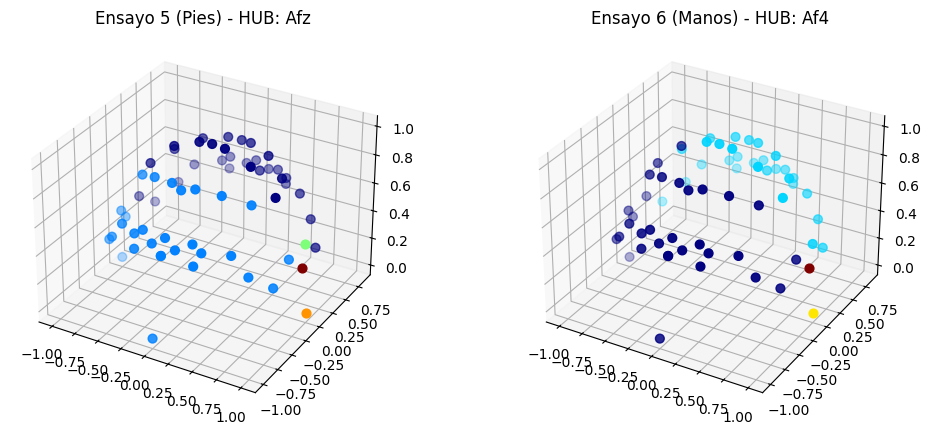

In [15]:
# subir dataset
ensayo5_excel = r"C:\Users\HP\Documents\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_05.xlsx"
ensayo6_excel = r"C:\Users\HP\Documents\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_06.xlsx"

try:
    ensayo5_dict = pd.read_excel(ensayo5_excel, sheet_name=None, index_col=None)
    ensayo6_dict = pd.read_excel(ensayo6_excel, sheet_name=None, index_col=None)

    # lista de dataframes
    ensayos5_dfs = lista_dfs(ensayo5_dict)
    ensayos6_dfs = lista_dfs(ensayo6_dict)

    # compactar a una matriz (Capsula)
    # Usamos umbrales arbitrarios o derivados del análisis anterior
    resultado5_df = capsula(ensayos5_dfs, 0.4, 0.6) 
    resultado6_df = capsula(ensayos6_dfs, 0.4, 0.6)

    # Grafos y Métricas
    G5 = nx.from_pandas_adjacency(resultado5_df)
    G6 = nx.from_pandas_adjacency(resultado6_df)
    
    metrics5 = metricas_grafo(G5)
    metrics6 = metricas_grafo(G6)
    
    hub5 = sorted(metrics5[5].items(), key=lambda x: x[1], reverse=True)[0] if metrics5[5] else ("Nan",0)
    hub6 = sorted(metrics6[5].items(), key=lambda x: x[1], reverse=True)[0] if metrics6[5] else ("Nan",0)

    # Grafo de comunidades Comparativo
    fig = plt.figure(figsize=(12, 5))
    axes = [fig.add_subplot(1, 2, 1, projection='3d'), 
            fig.add_subplot(1, 2, 2, projection='3d')]

    grafo_comunidades(metrics5[3], hub5, eeg_coords, axes[0])
    axes[0].set_title(f"Ensayo 5 (Pies) - HUB: {hub5[0]}")
    
    grafo_comunidades(metrics6[3], hub6, eeg_coords, axes[1])
    axes[1].set_title(f"Ensayo 6 (Manos) - HUB: {hub6[0]}")
    
    plt.show()

except Exception as e:
    print(f"Error procesando ensayos 5/6: {e}")